In [ ]:
import pandas as pd
import time
import sys
from pathlib import Path
import numpy as np

# Go up one directory to get to master/
project_root = str(Path.cwd().parent)
sys.path.append(project_root)



In [53]:
def get_solutions_all_folds_pulp(name_dataset: str, depth=3, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

#sol_dict = get_solutions_all_folds_pulp(name_dataset=name_dataset, depth= max_depth_available)

#print(sol_dict[4][8]['train'])

damit das hier immer funktioniert, muss das mapping vom binarizer auf die Zahlen immer gleich sein

Achtung: Man muss noch in den Ergebnissen zuordnen was in den Ursprungsdatensatz (das binarized wurde) als positive und was als negative gesehen wird. Also wie das label jetzt heißt dem ursprünglichen label zuordnen

=> Ich habe mich entschieden das schon beim binarizen zu machen

In [54]:
def acc_sens_spec_prec_bin(solution, pos_represent, neg_represent):
    tp = len(solution[(solution['y'] == pos_represent) & (solution['prediction'] == pos_represent)])
    tn = len(solution[(solution['y'] == neg_represent) & (solution['prediction'] == neg_represent)])
    fp = len(solution[(solution['y'] == neg_represent) & (solution['prediction'] == pos_represent)])
    fn = len(solution[(solution['y'] == pos_represent) & (solution['prediction'] == neg_represent)])
    number_datapoints = tp+tn+fp+fn
    if number_datapoints != len(solution):
        print('error in calculation of acc')
    sensitivity = tp/(tp+fn) #also called recall, True Positive Rate
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/number_datapoints
    return accuracy, sensitivity, specificity,precision


In [55]:
# does not contain time stuff
def solutions_all_depths_all_folds_bin(dataset_name, pos_represent, neg_represent, max_tree_depth, folds_available):
    sol_dict = get_solutions_all_folds_pulp(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    result_dict = dict()
    for depth in range(2,max_tree_depth+1):
        result_dict[depth] = dict()
        result_dict[depth]['test'] = dict()
        result_dict[depth]['train'] = dict()
        sensitivity_test, specificity_test, precision_test, accuracy_test = 0, 0, 0, 0
        sensitivity_train, specificity_train, precision_train, accuracy_train = 0, 0, 0, 0
        for fold in range(1, folds_available+1):
            sol_test = sol_dict[fold][depth]['test']
            sol_train = sol_dict[fold][depth]['train']
            acc_fold_test, sens_fold_test, spec_fold_test, prec_fold_test = acc_sens_spec_prec_bin(sol_test, pos_represent, neg_represent)
            acc_fold_train, sens_fold_train, spec_fold_train, prec_fold_train = acc_sens_spec_prec_bin(sol_train, pos_represent, neg_represent)

            sensitivity_test += sens_fold_test
            specificity_test += spec_fold_test
            precision_test += prec_fold_test
            accuracy_test += acc_fold_test

            sensitivity_train += sens_fold_train
            specificity_train += spec_fold_train
            precision_train += prec_fold_train
            accuracy_train += acc_fold_train
        
        result_dict[depth]['test']['sensitivity'] = sensitivity_test/folds_available
        result_dict[depth]['test']['specificity'] = specificity_test/folds_available
        result_dict[depth]['test']['precision'] = precision_test/folds_available
        result_dict[depth]['test']['accuracy'] = accuracy_test/folds_available

        result_dict[depth]['train']['sensitivity'] = sensitivity_train/folds_available
        result_dict[depth]['train']['specificity'] = specificity_train/folds_available
        result_dict[depth]['train']['precision'] = precision_train/folds_available
        result_dict[depth]['train']['accuracy'] = accuracy_train/folds_available
    return result_dict





In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# does not contain time stuff
def solutions_all_depths_all_folds_multiclass(dataset_name, pos_represent, neg_represent, max_tree_depth, folds_available):
    sol_dict = get_solutions_all_folds_pulp(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    result_dict = dict()
    for depth in range(2,max_tree_depth+1):
        result_dict[depth] = dict()
        result_dict[depth]['test'] = dict()
        result_dict[depth]['train'] = dict()
        sensitivity_test, specificity_test, precision_test, accuracy_test = 0, 0, 0, 0
        sensitivity_train, specificity_train, precision_train, accuracy_train = 0, 0, 0, 0
        for fold in range(1, folds_available+1):
            sol_test = sol_dict[fold][depth]['test']
            sol_train = sol_dict[fold][depth]['train']
            acc_fold_test, sens_fold_test, spec_fold_test, prec_fold_test = acc_sens_spec_prec_bin(sol_test, pos_represent, neg_represent)
            acc_fold_train, sens_fold_train, spec_fold_train, prec_fold_train = acc_sens_spec_prec_bin(sol_train, pos_represent, neg_represent)

            sensitivity_test += sens_fold_test
            specificity_test += spec_fold_test
            precision_test += prec_fold_test
            accuracy_test += acc_fold_test

            sensitivity_train += sens_fold_train
            specificity_train += spec_fold_train
            precision_train += prec_fold_train
            accuracy_train += acc_fold_train
        
        result_dict[depth]['test']['sensitivity'] = sensitivity_test/folds_available
        result_dict[depth]['test']['specificity'] = specificity_test/folds_available
        result_dict[depth]['test']['precision'] = precision_test/folds_available
        result_dict[depth]['test']['accuracy'] = accuracy_test/folds_available

        result_dict[depth]['train']['sensitivity'] = sensitivity_train/folds_available
        result_dict[depth]['train']['specificity'] = specificity_train/folds_available
        result_dict[depth]['train']['precision'] = precision_train/folds_available
        result_dict[depth]['train']['accuracy'] = accuracy_train/folds_available
    return result_dict

# Auswertung für jeden Datensatz

Was positive/negative target var ist und wovon sie repräsentiert wird, kann man in der jeweiligen Datei nachschauen

In [57]:
# <=50K:1; >50K:2
#result_dict_adult = solutions_all_depths_all_folds_bin(dataset_name='adult', pos_represent=1, neg_represent=2, max_tree_depth=8, folds_available=10)

#print(result_dict_adult[8]['test']['accuracy'])

Ausprobieren

In [58]:
sol_dict_adult = get_solutions_all_folds_pulp(name_dataset='adult', depth=8, folds_available = 10)

print(sol_dict_adult[1][8]['test']) #fold, depth, datatype



      Unnamed: 0  y  prediction  leaf
0              0  1           1   479
1             24  1           1   511
2             32  1           1   479
3             76  1           1   383
4             78  1           1   503
...          ... ..         ...   ...
4880       48831  1           1   303
4881       48832  1           1   303
4882       48833  1           1   300
4883       48839  1           2   351
4884       48841  2           2   349

[4885 rows x 4 columns]


In [59]:
 #y_true and y_pred are your true and predicted class labels, respectively
# report = classification_report(y_true, y_pred)

report_adult = classification_report(sol_dict_adult[1][8]['test']['y'], sol_dict_adult[1][8]['test']['prediction'])
print(report_adult)

              precision    recall  f1-score   support

           1       0.85      0.94      0.89      3716
           2       0.70      0.46      0.56      1169

    accuracy                           0.82      4885
   macro avg       0.77      0.70      0.72      4885
weighted avg       0.81      0.82      0.81      4885



In [60]:
accuracy = accuracy_score(sol_dict_adult[1][8]['test']['y'], sol_dict_adult[1][8]['test']['prediction'])
print(accuracy)

0.824360286591607


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#y_true = [...]  # true labels
#y_pred = [...]  # predicted labels

sol_dict_nursery = get_solutions_all_folds_pulp(name_dataset='nursery', depth=8, folds_available = 10)

# Compute confusion matrix
cm = confusion_matrix(sol_dict_nursery[1][8]['test']['y'], sol_dict_nursery[1][8]['test']['prediction'])

#tn, fp, fn, tp = cm.ravel() #just for binary?
# For binary classification, cm looks like:
# [[TN, FP],
#  [FN, TP]]

print(cm)
print(cm[0])
print(cm.ravel())


[[432   0   0   0   0]
 [  0 397   0  20   9]
 [  0   0   0   0   1]
 [  0  26   0 378   0]
 [  0  15   0   0  18]]
[432   0   0   0   0]
[432   0   0   0   0   0 397   0  20   9   0   0   0   0   1   0  26   0
 378   0   0  15   0   0  18]


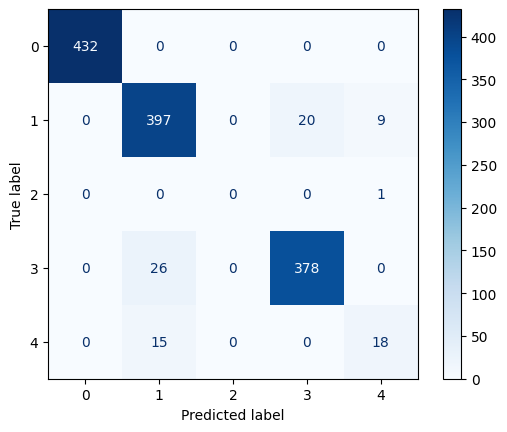

In [62]:
# Optional: specify class labels for better readability
# class_names = [0, 1, 2]

# Create and plot confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) #, display_labels=class_names)
disp.plot(cmap="Blues")  # You can change colormap here
plt.show()

In [ ]:
def get_class_confusion_values(cm, class_idx):
    TP = cm[class_idx, class_idx]
    FN = cm[class_idx, :].sum() - TP
    FP = cm[:, class_idx].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    return TP, FP, FN, TN

# Example usage with confusion matrix cm and number of classes n_classes
for i in range(cm.shape[0]):
    TP, FP, FN, TN = get_class_confusion_values(cm, i)
    print(f"Class {i}: TP={TP}, FP={FP}, FN={FN}, TN={TN}")